# VAR-Model for money supply M2, inflation rate and gdp in the US

### Importing the relevant libraries

In [144]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Importing the relevant datasets

In [145]:
money = pd.read_csv("M2SL.csv") # money supply M2 in billion US-dollars

gdp = pd.read_csv("GDP.csv") # US GDP per capita

inflation = pd.read_csv("inflation.csv") # Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (1982-1984 = 100)

### Cleaning the datasets

In [146]:
# Changing columns names

money = money.rename(columns={"DATE": "date", "M2SL": "M2"}).copy()

inflation = inflation.rename(columns={"DATE": "date", "CPIAUCSL": "inflation"}).copy()

gdp = gdp.rename(columns={"DATE": "date", "GDP": "gdp"}).copy()

In [147]:
# Changing the date-column to datetime-format

money["date"] = pd.to_datetime(money["date"]).copy()

gdp["date"] = pd.to_datetime(gdp["date"]).copy()

inflation["date"] = pd.to_datetime(inflation["date"]).copy()

### Setting all datasets to the same frequency and time-span

In [148]:
money_min = money["date"].min()
money_max = money["date"].max()

gdp_min = gdp["date"].min()
gdp_max = gdp["date"].max()

inflation_min = inflation["date"].min()
inflation_max = inflation["date"].max()

In [149]:
df_min = pd.DataFrame({"min": [money_min, gdp_min, inflation_min]},
                      index = ["money_min", "gdp_min", "inflation_min"])

df_max = pd.DataFrame({"max": [money_max, gdp_max, inflation_max]},
                      index = ["money_max", "gdp_max", "inflation_max"])

In [150]:
df_min["min"].max() # 1960-01-01 will be our threshold on the bottom

Timestamp('1959-01-01 00:00:00')

In [151]:
df_max["max"].min() # 2023-01-01 will be our threshold on top

Timestamp('2024-04-01 00:00:00')

In [152]:
# Deleting all rows above or below our thresholds

money = money.iloc[:784].copy()

inflation = inflation[144:928].copy()
inflation.reset_index(inplace=True)

gdp = gdp.iloc[48:].copy()
gdp.reset_index(inplace=True)

In [153]:
inflation.drop(columns=["index"], inplace=True)
gdp.drop(columns=["index"], inplace=True)

In [154]:
# Deleting the rows, so that every time-series has the same frequency

money = money.iloc[::3].copy()
inflation = inflation[::3].copy()

In [155]:
# Setting the date as index-column

money = money.set_index("date").copy()

gdp = gdp.set_index("date").copy()

inflation = inflation.set_index("date").copy()

### Testing money-dataset for stationarity

Text(0, 0.5, 'M2')

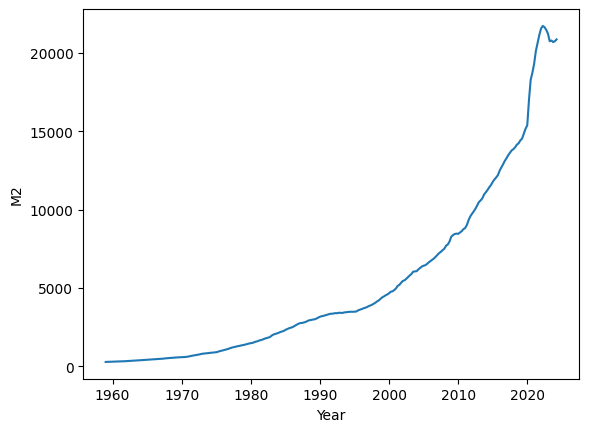

In [156]:
# Plotting money

fig, ax = plt.subplots()
ax.plot("M2", data=money)
ax.set_xlabel("Year")
ax.set_ylabel("M2")

# From pure observation, the time-series is probably not stationary

In [157]:
# Augmented Dickey-Fuller-Test is used for testing

result = adfuller(money["M2"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
for key, value in result[4].items():
    print("Critical values:")
    print(f"  {key} {value}")

# A p-value which is equal to one is very unlikely but possible due to rounding
# The time-series is non-stationary, because we cannot reject the null-hypothesis

ADF Statistic: 5.002219
p-value: 1.000000
Critical values:
  1% -3.4573260719088132
Critical values:
  5% -2.873410402808354
Critical values:
  10% -2.573095980841316


In [158]:
# Differencing the time-series to achieve stationarity

money_diff = money.copy()

money_diff["M2"] = money["M2"].diff().copy()

In [159]:
# Drop the row with the missing value

money_diff = money_diff.dropna().copy()

# Again testing for stationarity

result = adfuller(money_diff["M2"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
for key, value in result[4].items():
    print("Critical values:")
    print(f"  {key} {value}")

# The p-value > 0.05, the time-series is not stationary after differencing for one time
# The time-series is therefore not integrated by order 1: I(1)
# Differencing again to achieve stationarity

ADF Statistic: 1.738590
p-value: 0.998219
Critical values:
  1% -3.457437824930831
Critical values:
  5% -2.873459364726563
Critical values:
  10% -2.573122099570008


Text(0, 0.5, 'M2-diff')

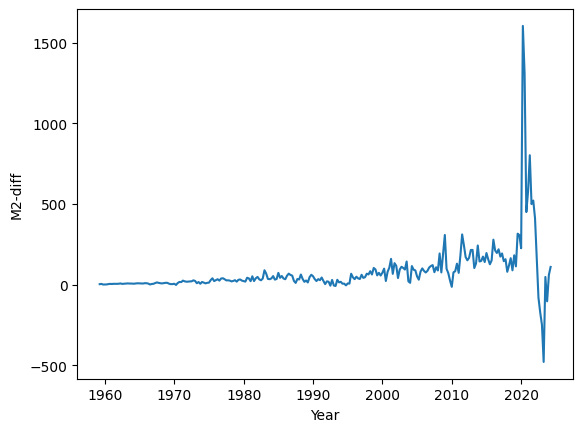

In [160]:
# Plotting the time-series again

fig, ax = plt.subplots()
ax.plot("M2", data=money_diff)
ax.set_xlabel("Year")
ax.set_ylabel("M2-diff")

In [161]:
# Differencing the time-series again to achieve stationarity

money_diff_2 = money_diff.copy()

money_diff_2["M2"] = money_diff["M2"].diff().copy()

In [162]:
# Drop the row with the missing value

money_diff_2 = money_diff_2.dropna().copy()

# Again testing for stationarity

result = adfuller(money_diff_2["M2"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
for key, value in result[4].items():
    print("Critical values:")
    print(f"  {key} {value}")

# The p-value < 0.05, the time-series is now stationary after differencing twice
# The time-series is therefore integrated by order 1: I(2)

ADF Statistic: -7.569492
p-value: 0.000000
Critical values:
  1% -3.457437824930831
Critical values:
  5% -2.873459364726563
Critical values:
  10% -2.573122099570008


Text(0, 0.5, 'M2-diff')

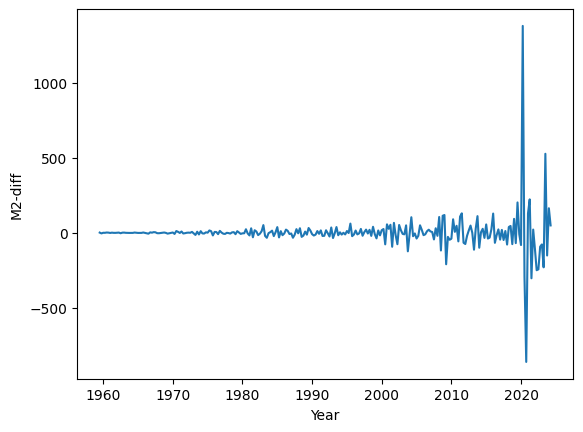

In [163]:
# Plotting the stationary time-series

fig, ax = plt.subplots()
ax.plot("M2", data=money_diff_2)
ax.set_xlabel("Year")
ax.set_ylabel("M2-diff")

### Testing inflation-dataset for stationarity

Text(0, 0.5, 'CPI')

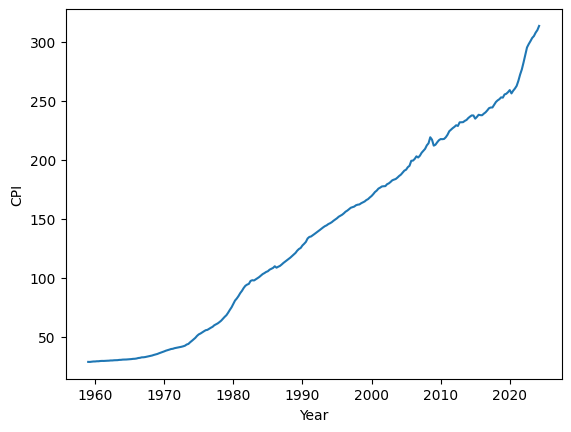

In [164]:
# Plotting inflation (CPI)

fig, ax = plt.subplots()
ax.plot("inflation", data=inflation)
ax.set_xlabel("Year")
ax.set_ylabel("CPI")

# From pure observation, the time-series is probably not stationary

In [165]:
# Augmented Dickey-Fuller-Test is used for testing

result = adfuller(inflation["inflation"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
for key, value in result[4].items():
    print("Critical values:")
    print(f"  {key} {value}")

# The time-series is non-stationary, because we cannot reject the null-hypothesis

ADF Statistic: 2.116012
p-value: 0.998806
Critical values:
  1% -3.4561550092339512
Critical values:
  5% -2.8728972266578676
Critical values:
  10% -2.5728222369384763


In [166]:
# Differencing the time-series to achieve stationarity

inflation_diff = inflation.copy()

inflation_diff["inflation"] = inflation["inflation"].diff().copy()

In [167]:
# Drop the row with the missing value

inflation_diff = inflation_diff.dropna().copy()

# Again testing for stationarity

result = adfuller(inflation_diff["inflation"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
for key, value in result[4].items():
    print("Critical values:")
    print(f"  {key} {value}")

# The p-value > 0.05, the time-series is now stationary after differencing for one time
# The time-series is therefore integrated by order 1: I(1)

ADF Statistic: -3.688511
p-value: 0.004278
Critical values:
  1% -3.4561550092339512
Critical values:
  5% -2.8728972266578676
Critical values:
  10% -2.5728222369384763


Text(0, 0.5, 'inflation')

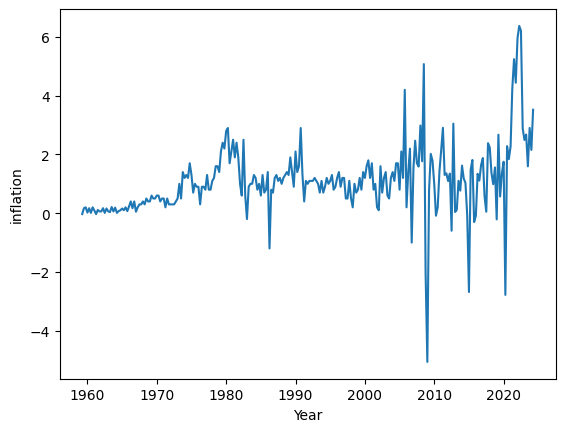

In [168]:
# Plotting the time-series again

fig, ax = plt.subplots()
ax.plot("inflation", data=inflation_diff)
ax.set_xlabel("Year")
ax.set_ylabel("inflation")

### Testing gdp-dataset for stationarity

Text(0, 0.5, 'gdp')

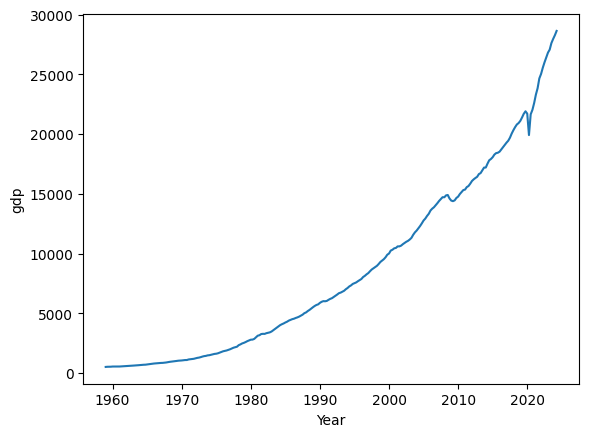

In [169]:
# Plotting inflation (CPI)

fig, ax = plt.subplots()
ax.plot("gdp", data=gdp)
ax.set_xlabel("Year")
ax.set_ylabel("gdp")

# From pure observation, the time-series is probably not stationary

In [170]:
# Augmented Dickey-Fuller-Test is used for testing

result = adfuller(gdp["gdp"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
for key, value in result[4].items():
    print("Critical values:")
    print(f"  {key} {value}")

# The p-value is probably near 1 and rounded
# The time-series is non-stationary, because we cannot reject the null-hypothesis

ADF Statistic: 7.566008
p-value: 1.000000
Critical values:
  1% -3.4557539868570775
Critical values:
  5% -2.8727214497041422
Critical values:
  10% -2.572728476331361


In [171]:
# Differencing the time-series to achieve stationarity

gdp_diff = gdp.copy()

gdp_diff["gdp"] = gdp["gdp"].diff().copy()

In [172]:
# Drop the row with the missing value

gdp_diff = gdp_diff.dropna().copy()

# Again testing for stationarity

result = adfuller(gdp_diff["gdp"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
for key, value in result[4].items():
    print("Critical values:")
    print(f"  {key} {value}")

# The p-value > 0.05, the time-series is now stationary after differencing for one time
# The time-series is therefore integrated by order 1: I(1)

ADF Statistic: -3.883841
p-value: 0.002157
Critical values:
  1% -3.4561550092339512
Critical values:
  5% -2.8728972266578676
Critical values:
  10% -2.5728222369384763


Text(0, 0.5, 'gdp-diff')

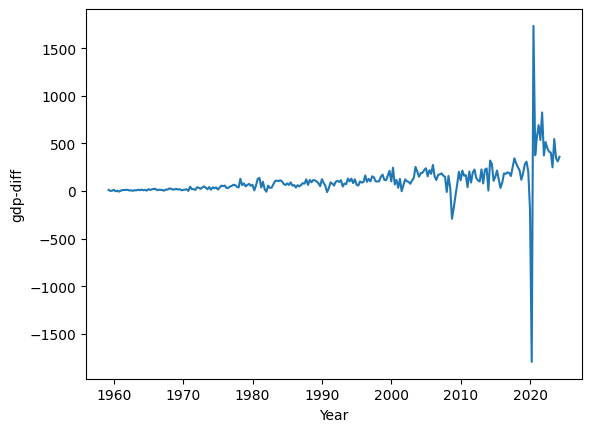

In [173]:
# Plotting the time-series again

fig, ax = plt.subplots()
ax.plot("gdp", data=gdp_diff)
ax.set_xlabel("Year")
ax.set_ylabel("gdp-diff")